In [1]:
import numpy as np
from time import perf_counter

DISPLAY_WIDTH, DISPLAY_HEIGHT = 600, 600
HISTO_WIDTH, HISTO_HEIGHT = 255, 100
PANEL_WIDTH, PANEL_HEIGHT = 300, DISPLAY_HEIGHT
WIDTH, HEIGHT = DISPLAY_WIDTH + PANEL_WIDTH, DISPLAY_HEIGHT

BUTTON_X, BUTTON_Y = DISPLAY_WIDTH + (PANEL_WIDTH - HISTO_WIDTH), HEIGHT * 5/6
BUTTON_WIDTH, BUTTON_HEIGHT = 150, 35

THRESHOLD_NUM_PIXEL = 15

button_clicked = False

def setup():    
    size(WIDTH, HEIGHT)

#     # Calculate min and max value for each color channel
#     max_rgb = (np.max(photo.np_pixels[..., 1]), np.max(photo.np_pixels[..., 2]), np.max(photo.np_pixels[..., 3]))
#     min_rgb = (np.min(photo.np_pixels[..., 1]), np.min(photo.np_pixels[..., 2]), np.min(photo.np_pixels[..., 3]))
#     print(f'{max_rgb=}')
#     print(f'{min_rgb=}')
    
#     no_stroke()
    background(0)
    no_loop()
    
def draw():
    global photo
    global min_red, max_red
    global min_green, max_green
    global min_blue, max_blue
    
    if not button_clicked:
        # Load original image
        photo = load_image("../Lenna_(test_image).png")
        photo.load_np_pixels()
    else:
        # Auto color correction, we map the color values to cover the whole range [0,255] 
        photo.np_pixels[..., 1] = np.interp(photo.np_pixels[..., 1], [min_red, max_red], [0, 255]).astype(np.uint8)
        photo.np_pixels[..., 2] = np.interp(photo.np_pixels[..., 2], [min_green, max_green], [0, 255]).astype(np.uint8)
        photo.np_pixels[..., 3] = np.interp(photo.np_pixels[..., 3], [min_blue, max_blue], [0, 255]).astype(np.uint8)
        photo.update_np_pixels()
    
    # Calculate the histograms for each color channel 
    histo_red = np.bincount(photo.np_pixels[..., 1].flatten(), minlength= 256)
    histo_green = np.bincount(photo.np_pixels[..., 2].flatten(), minlength= 256)
    histo_blue = np.bincount(photo.np_pixels[..., 3].flatten(), minlength= 256)
    
    # If the number of pixels with this value is below the threshold, we discard them from the histogram
    # In practice, crop the 'tails' of the histogram, where the number of pixels is really low and slowly climbing
    # Make the color correction way more pronounced
    # To desactivate, put threshold to 1
    def threshold(histo):
        histo[histo < THRESHOLD_NUM_PIXEL] = 0

    threshold(histo_red)
    threshold(histo_green)
    threshold(histo_blue)
    
    def min_max_histo(histo):
        histo_nonzero = np.nonzero(histo)
        return histo_nonzero[0][0], histo_nonzero[0][-1]
        
    # We extract the min and max value for each color channel,
    # by looking at the first and last non zero value in the histogram
    min_red, max_red = min_max_histo(histo_red)
    min_green, max_green = min_max_histo(histo_green)
    min_blue, max_blue = min_max_histo(histo_blue)
    print(f'{min_red=}, {max_red=}')
    print(f'{min_green=}, {max_green=}')
    print(f'{min_blue=}, {max_blue=}')
    
    def normalize_array(histo):
        # min value is always 0 so we don't include it in the formula
        histo_scaled = histo / np.max(histo)
        return histo_scaled
    
    # We normalize the histograms so that each value is between 0 and 1
    histo_red_normalized = normalize_array(histo_red)
    histo_green_normalized = normalize_array(histo_green)
    histo_blue_normalized = normalize_array(histo_blue)    
        
    ##################################################################
    
    # Draw image
    fill(0)
    stroke(0)
    rect(0, 0, DISPLAY_WIDTH, DISPLAY_HEIGHT)
    image_mode(CENTER)
    image(photo, DISPLAY_WIDTH/2, DISPLAY_HEIGHT/2)
    
    # Draw histograms
    with push_matrix():
        stroke(255)
        fill(255)
        translate(DISPLAY_WIDTH, (height - 3 * HISTO_HEIGHT)/2)

        col_red = 0xFFFF0000
        col_green = 0xFF00FF00
        col_blue = 0xFF0000FF

        for col, histo_normalized in zip([col_red, col_green, col_blue], [histo_red_normalized, histo_green_normalized, histo_blue_normalized]):
            it = np.nditer(histo_normalized, flags=['f_index'])

            # Draw background
            stroke(0)
            rect(0, 0, HISTO_WIDTH, HISTO_HEIGHT)

            translate(0, HISTO_HEIGHT)
            stroke(col)
            for v in it:        
                    rect(it.index, 0, 1, -v * HISTO_HEIGHT)
                
    # Draw button
    with push_matrix():
        translate(BUTTON_X, BUTTON_Y)
        stroke(255)
        fill(127)
        
        rect(0,0 , BUTTON_WIDTH, BUTTON_HEIGHT)
        fill(255)
        translate(BUTTON_WIDTH/2, BUTTON_HEIGHT/2)
        text_align(CENTER, CENTER)
        text_size(16)
        if not button_clicked:
            text("Auto color correction", 0, 0)
        else:
            text("Original", 0, 0)
        
    save_frame("./histogram.png", use_thread=True) 

def mouse_clicked():
    global button_clicked
    
    if (BUTTON_X <= mouse_x <= BUTTON_X + BUTTON_WIDTH) and (BUTTON_Y <= mouse_y <= BUTTON_Y + BUTTON_HEIGHT):
        print('> Clicked!')
        button_clicked = not button_clicked
        redraw()
            
run_sketch()

min_red=63, max_red=255
min_green=4, max_green=227
min_blue=45, max_blue=214
> Clicked!
min_red=0, max_red=255
min_green=0, max_green=255
min_blue=0, max_blue=255


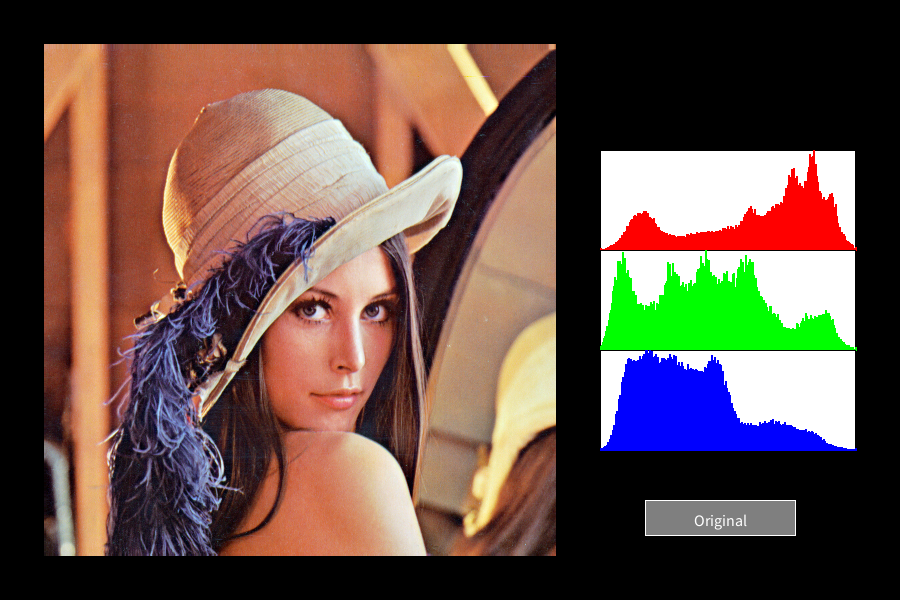